In [ ]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [ ]:
samples = 20000
df = pd.read_csv("train.csv")
base_path = "./images/"
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [ ]:
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

Size of training data: (20001, 3)
Number of unique classes: 16342


In [ ]:
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True)
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))

   landmark_id  count
0     138982.0     57
1     177870.0     22
2      62798.0     20
3     192931.0     16
4      83144.0     14
5     171772.0     14
6     176528.0     14
7      45428.0     11
8      84689.0     10
9     164773.0     10
       landmark_id  count
16332     147159.0      1
16333      20310.0      1
16334      80664.0      1
16335     149246.0      1
16336     162189.0      1
16337      61959.0      1
16338     194142.0      1
16339     171822.0      1
16340      55962.0      1
16341       4406.0      1


count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64


Text(0, 0.5, 'Occurences')

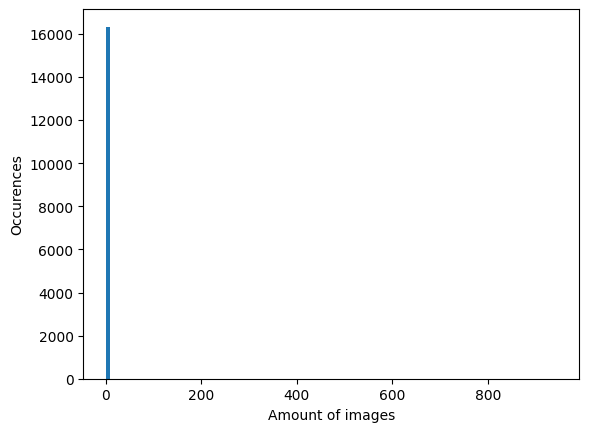

In [ ]:
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")

Amount of classes with less than or equal to five datapoints: 16281
Amount of classes between five and 10 datapoints: 53


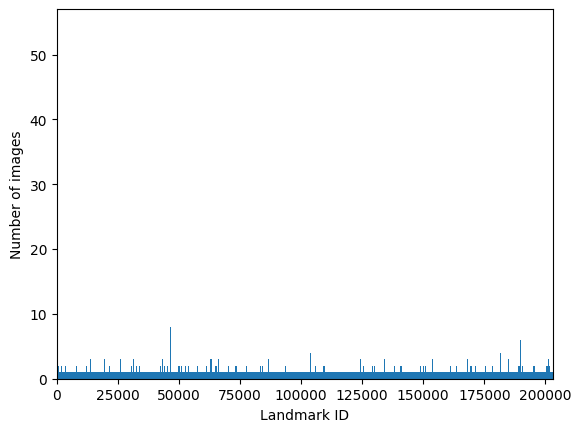

In [ ]:
# Assuming `data` contains 'count' and 'landmark_id'
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0, 5)).sum())
print("Amount of classes between five and 10 datapoints:", (data['count'].between(6, 10)).sum())

# Plotting histogram
n = plt.hist(df["landmark_id"], bins=sorted(df["landmark_id"].unique()))
freq_info = n[0]
plt.xlim(0, df['landmark_id'].max())
plt.ylim(0, df['landmark_id'].value_counts().max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

4 sample images from random classes:


FileNotFoundError: [Errno 2] No such file or directory: '/images/'

<Figure size 1600x1600 with 0 Axes>

In [ ]:

from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09
# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")

In [ ]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")

Training on: 16000 samples
Validation on: 4001 samples
Epoch:  1/15


ValueError: too many values to unpack (expected 2)

In [ ]:
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()


ValueError: too many values to unpack (expected 2)